### Hugo Englund | 2020-11-27

# Laboration 3: Part A
## Outline
The aim of this labarotaion is to analyze the Fashion MNIST dataset by transfer learning, through the following steps:
1. Import the pretrained VGG16 model from Keras.
2. Scale the images to be applicable in the model.
3. Modify the layers in the model, as well as adding layers to adjust the model to the given classification problem.
4. Train and the test the modified VGG16 model.
5. Compare the modified model against the best ones from previous laborations.


#### Import relevant packages

In [ ]:
# import relevant packages
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2

print(tf.__version__)

2.3.0


#### (Performance plot function)

In [ ]:
# plots accuracy and loss for training and validation, respectively
def plot_performance(history):
  # plot accuracy during training and validation
  plt.plot(history.history["accuracy"], label="Training\naccuracy")
  plt.plot(history.history["val_accuracy"], label="Validation\naccuracy")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.ylim([0.5, 1])
  plt.legend(loc="best")
  plt.title("Training and validation accuracies")
  plt.grid(b=True)
  plt.show()

  # plot loss during training and validation
  plt.plot(history.history["loss"], label="Training\nloss")
  plt.plot(history.history["val_loss"], label='Validation\nloss')
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.ylim([0, 0.5])
  plt.legend(loc="best")
  plt.title("Training and validation losses")
  plt.grid(b=True)
  plt.show()
  return

#### Import the Fashion MNIST data set

In [ ]:
# fetch data
fashion_mnist = tf.keras.datasets.fashion_mnist

# Save class names since they are not included in the imported data set
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# load data and split to train and test sets
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

#### Data preparation
Before the modelling, we prepare the data by:
1. Scaling the images to at least 32x32 pixels since it is the smallest dimension applicable in VGG16.
2. Adding another dimension to the images as the RGB-channel, required in the model.
3. Verifying that the image scaling went correctly by plotting some images and investigating their dimensions.
4. Normalizing the data to a range between 0 and 1, in order for the features in each image to be in a common scale.
5. Converting the labels to one-hot encoded vectors since we have multiple outputs in the model.

In [ ]:
# define desired dimension of scaled images
DIM = (32, 32)

# scale images to desired size and add RGB-channels, e.g. 32x32x3
train_images = np.array([cv2.cvtColor(cv2.resize(img, DIM), cv2.COLOR_GRAY2BGR) for img in train_images])
test_images = np.array([cv2.cvtColor(cv2.resize(img, DIM), cv2.COLOR_GRAY2BGR) for img in test_images])

#### Check that scaling went correctly

In [ ]:
# check dimension of train and test images
print("Dimension of scaled images:")
print("Training images: {}".format(train_images.shape))
print("Test images: {}".format(test_images.shape))

Dimension of scaled images:
Training images: (60000, 32, 32, 3)
Test images: (10000, 32, 32, 3)


Visualization of 25 random fashion objects:



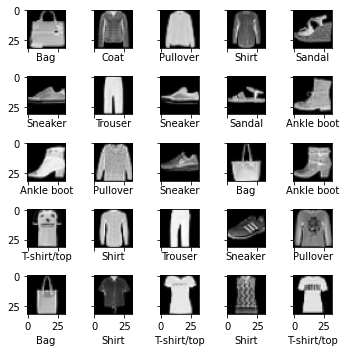

In [ ]:
# plots of 25 random fashion objects 
dim = 5
sample_ids = np.random.randint(0, len(train_images), dim**2)
sample_images = train_images[sample_ids, :]
sample_labels = train_labels[sample_ids]
fig, axes = plt.subplots(dim, dim, figsize=(dim,dim), sharex=True, sharey=True) 

for id in range(dim**2):
    row = id // dim 
    col = id % dim
    axis = axes[row, col]

    img = sample_images[id]
    axis.imshow(img)
    axis.set(xLabel=class_names[sample_labels[id]])

plt.tight_layout()
print("Visualization of {} random fashion objects:\n".format(dim**2))
plt.show()

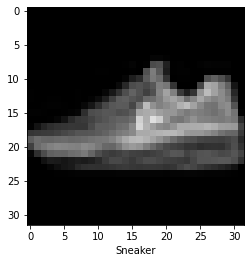

In [ ]:
# plot one random image in "full size" to verify that
# the image is of dimension 32x32
plt.imshow(train_images[sample_ids[12]])
plt.xlabel(class_names[sample_labels[12]])
plt.show()

#### Conlusions from image scaling
Based on the plots there are no indications that image scaling went wrong since all pictures looks fine, and the dimension of the images are 32x32x3 as desired.

#### Normalize images and convert labels


In [ ]:
from keras.utils.np_utils import to_categorical 
# normalize image pixels
train_images, test_images = train_images / 255.0, test_images / 255.0

# convert labels to one-hot encoded vectors
train_labels, test_labels = to_categorical(train_labels, num_classes=10), to_categorical(test_labels, num_classes=10)

#### Import the pretrained VGG16 model
We import the pretrained model and set its layers to be untrainable. The "top", i.e. the three fully-connected layers at the top of the model, is not included since we want to have a custom input shape of 32x32x3 (default is 224x224x3).

In [ ]:
# import pretrained model
vgg = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(DIM[0], DIM[0], 3),
)

# make the imported layers nontrainable
vgg.trainable = False

# summarize the model
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

#### Modify the VGG16 model 
Modify the pretrained model by removing all existing layers beyond "block3_pool", and adding additional dense layers, with regularization, suitable for our problem. More specifically:
1. Pretrained VGG16 model with the first three convolutional sequences.
2. Additonal, trainable dense layers with ReLu-activation function and regularization corresponding to batch normalization and dropout of rate 0.5:
    - 4096 units
    - 4096 units
    - 2048 units
    - 1024 units
    - 516 units
    - 516 units

3. Softmax activation with 10 units.

This is done by Keras functional API in which we chain layer calls to create a modified model.

In [ ]:
from tensorflow.keras import layers
from keras.models import Model

# reduce the model by removing all layers beyond "block3_pool"
vgg_reduced = Model(inputs=vgg.input, outputs=vgg.layers[-9].output)

# add custom layers to the reduced model
flatten = layers.Flatten()(vgg_reduced.output)

# dense layer 1
x = layers.Dense(4096, activation='relu')(flatten)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.50)(x)

# dense layer 2
x = layers.Dense(4096, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.50)(x)

# dense layer 3
x = layers.Dense(2048, activation='relu')(x) 
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.50)(x)

# dense layer 4
x = layers.Dense(1024, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.50)(x)

# dense layer 5
x = layers.Dense(516, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.50)(x)

# dense layer 6
x = layers.Dense(516, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.50)(x)

# activation layer
out = layers.Dense(10, activation='softmax')(x)

# build the modified model
vgg_mod = Model(inputs=vgg_reduced.input, outputs=out)

# print out summary of the model
vgg_mod.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)        

#### Compile the modified model
We use the Adam optimizer with a learning rate of 0.001.


In [ ]:
from keras.optimizers import Adam

# define optimizer
optimizer = Adam(learning_rate=0.001)

# Compile the model 
vgg_mod.compile(
    optimizer = optimizer,
    loss = "categorical_crossentropy", 
    metrics=["accuracy"]
)

#### Train the modified model
The validation split is set to the fraction corresponding to exactly 10000 images. Thus, we get an approximate 70`/`15`/`15%-split between training, testing and validation images, respectively. 

In addition, early stopping with a patience of two epochs is used in the model, which is that if the validation loss is no longer decreasing in four consecutive epochs, the training is terminated. This used to prevent excessive training times and foremost overfitting. The callback to reduction of the learning rate is also used in this model, which reduces the learning rate if the validation loss has not decreased between two epochs.

We use 30 epochs and a batch size of 50.

In [ ]:
# define epochs and batch size
epochs = 30
batch_size = 50

# callback: early stopping 
early_stop = tf.keras.callbacks.EarlyStopping(patience=2, verbose=1)

# callback: reduced learning rate on plateau
reduce_learning = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=1,
    verbose=1,
    mode='auto',
    min_delta=0.0001,
    cooldown=1,
    min_lr=0
)

# fit the model
history = vgg_mod.fit(
    train_images,
    train_labels,
    batch_size=batch_size,
    validation_split=1/6,
    epochs=epochs,
    callbacks=[early_stop, reduce_learning]
)

Epoch 1/30
1000/1000 [==============================] - 13s 13ms/step - loss: 0.6283 - accuracy: 0.7913 - val_loss: 0.3054 - val_accuracy: 0.8906
Epoch 2/30
1000/1000 [==============================] - ETA: 0s - loss: 0.3901 - accuracy: 0.8654
Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1000/1000 [==============================] - 13s 13ms/step - loss: 0.3901 - accuracy: 0.8654 - val_loss: 0.3189 - val_accuracy: 0.8845
Epoch 3/30
1000/1000 [==============================] - 13s 13ms/step - loss: 0.3051 - accuracy: 0.8944 - val_loss: 0.2415 - val_accuracy: 0.9102
Epoch 4/30
1000/1000 [==============================] - 13s 13ms/step - loss: 0.2841 - accuracy: 0.9002 - val_loss: 0.2411 - val_accuracy: 0.9090
Epoch 5/30
1000/1000 [==============================] - 13s 13ms/step - loss: 0.2710 - accuracy: 0.9058 - val_loss: 0.2277 - val_accuracy: 0.9143
Epoch 6/30
1000/1000 [==============================] - 13s 13ms/step - loss: 0.2613 - accuracy: 0.907

#### Evaluate the model
The model is evaluated by analyzing the curves of loss and accuracy in both training and validation. 

Ideally, the curves of training and validation should be more or less identical in both accuracy and loss towards the last epochs, in order to obtain a generalized model.

However, there can be cases where the validation loss is consistently greater than the training loss. This indicates underfitting. 

On the contrary, if the validation loss follows the training loss and then starts to deviate by increasing, we are overfitting.

There could also be cases where the validation loss is consistently lesser than the training loss. There are three main reasons for this:
1. Regularization is applied during training, but not during validation.
2. Training loss is computed during each epoch, while validation loss is computed after each epoch. 
3. The validation set is "easier" than the training set.

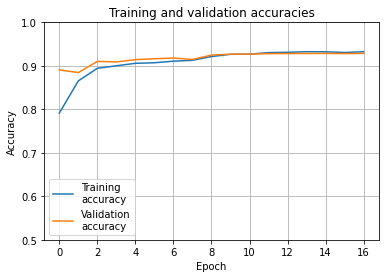

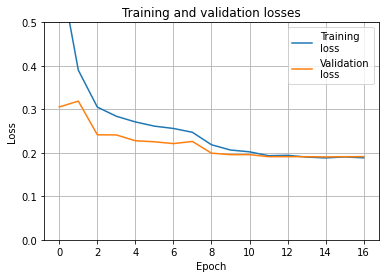

In [ ]:
# analyze training and validation accuracy/loss
plot_performance(history)

#### Test the modified model

In [ ]:
# test the model and print out the results
test_loss, test_acc = vgg_mod.evaluate(test_images, test_labels, verbose=0)
print("Test loss: {0:.{1}}".format(test_loss, 4))
print("Test accuracy: {0:.{1}}".format(test_acc, 4))

Test loss: 0.2063
Test accuracy: 0.9268


#### Model conclusion
Form the accuracy and loss plots, it can be seen that validation and accuracy loss barely differs from those in the training towards the last epochs. This is a quite clear indication of an adequately fitted model, neither over- or underfitted.

#### Discussion
Firstly, we obtained descent results from the modified VGG16 model. With test loss and accuracy of 0.2063 and accuracy of ~92.7%, respectively, as well as good fit. In both measures, this is slightly better than the best models from both laboration 1 and 2.

Further, the model in this laboration is of a completely different architecture than those in previous laborations. 

This model has: 
- 46,636,970 parameters of which 1,760,080 are non-trainable.

In laboration 1 and 2 (Part 1), the model had: 
- 1,678,954 parameters of which 1,344 were non-trainable.

The tuned model in laboration 2 (Part 2) had:
-  6,743,434 parameters of which 2,304 were non-trainable.

Since we had considerably smaller models in the previous laborations that only performed a litte worse, the large number of additional parameters in this model might tell us that the pretrained layers in the VGG16 perhaps not provide that much to this particular problem. The reasons for this can be that:

1. VGG16 is trained on larger, colorized images compared to the Fashion MNIST data that consists of smaller, grey-scale images. 
2. VGG16 is initially trained for classification of 1000 different classes, compared to 10 classes in our case.
3. The ImageNet data most likely contain noise that is captured in the pretrained weights, which decreases the perfomance of the model relative our problem.

Besides the differences in parameters, this model had a different set of hyperparameters and callbacks compared to the previous models such as:
- Adam optimizer with a learning rate of 0.001, compared to previous SGD with learning rate 0.01.
- Decreased batch size to 50, previously 100.
- Reduction of learning rate upon plateau with respect to validation loss, which was not utilized in previous models.

In addition, it would have been interesting to investigate how the reduced learning rate-callback would affect the previous models. Since it was necessary for this model to perform similarly, I believe that previous models would improved with this callback because they were constructed for this particular problem initially.


#### Conclusions
To conclude, the pretrained part of the modified VGG16 model did not improve the classification accuracy compared to previous models, since it required some large additional dense layers to perform similarly. However, this is not unexpected since the pretrained layers are trained on a completely different set of images compared to Fashion MNIST. Thus, letting, at least, some of the existing layers be trainable would most likely improve the model. 